In [10]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import TransformerMixin
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string
from sklearn.preprocessing import FunctionTransformer
import joblib
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score

In [11]:
# Read movie scripts from data directory and remove boilerplate
def get_script_from_id(id):
    script = open('../data/script/' + id + '.script', 'r').read()
    # print(script)
    script = script.replace("'", " ").replace('"', ' ').replace('\n', ' ').replace('\r', ' ').replace('\t', ' ').replace('\b', ' ').replace('\\', ' ')
    return script

# Merge script data with labels crawled in data gathering
def get_pd_dataframe():
    inputFile = open('../data_gathering/baseline/output/imdb_id_with_age_rating_and_labels.txt')
    df_data = []
    for line in inputFile:
        line_data = line.strip().split(',')
        # print(line_data)
        line_data.append(int(line_data[3]) + int(line_data[4]) + int(line_data[5]) + int(line_data[6]))
        
        max_index = 0
        max_value = 0
        for i in range(3,7):
            vote_count = int(line_data[i])
            if(vote_count >= max_value):
                max_index = i - 3
                max_value = vote_count
        line_data.append(max_index)
        try:
            script = get_script_from_id(line_data[0])
        except:
            # print('Error on loading script for id: ' + line_data[0])
            continue
        line_data.append(script)
        df_data.append(line_data)

    # id | Aspect | None | Mild | Moderate | Severe | Total_votes | Aspect_rating | text
    df = pd.DataFrame(df_data, columns=['imdb_id', 'age_rating', 'aspect', 'votes none', 'votes mild', 'votes moderate', 'votes severe', 'total_votes', 'aspect_rating', 'text'])
    df.drop(columns=["age_rating"], inplace=True)
    df = df.astype({'votes mild':'int', 'votes moderate':'int', 'votes severe':'int', 'votes none':'int', 'total_votes':'int', 'aspect_rating':'int'})
    return df

In [12]:
# Download standard datasets for filtering movie scripts
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

# Text preprocessing class for preprocessing of movie scripts
class TextPreprocessor(TransformerMixin):
    def __init__(self):
        self.stop_words = set(stopwords.words('english'))
        self.lemmatizer = WordNetLemmatizer()
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X_processed = []
        for text in X:
            # Convert to lowercase and remove punctuation
            text = text.lower().translate(str.maketrans('', '', string.punctuation))
            # Tokenize the text
            tokens = nltk.word_tokenize(text)
            # Remove stop words and lemmatize the remaining words
            processed_tokens = [self.lemmatizer.lemmatize(token) for token in tokens if token not in self.stop_words]
            # Join the processed tokens back into a single string
            processed_text = ' '.join(processed_tokens)
            X_processed.append(processed_text)
        return X_processed


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/leonremke/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/leonremke/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/leonremke/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [13]:
# Load the data
df = get_pd_dataframe()

# Drop rows with less than 5 votes
rows_to_drop = df.loc[df['total_votes'] < 5].index
df = df.drop(rows_to_drop)

# Group the dataframe by 'aspect' and create a dictionary of dataframes
df_dict = {aspect: aspect_df.drop('aspect', axis=1) for aspect, aspect_df in df.groupby('aspect')}
for aspect, aspect_df in df_dict.items():
    aspect_df.drop(columns=['votes none', 'votes mild', 'votes moderate', 'votes severe', 'total_votes'], inplace=True)

In [14]:
np.random.seed(100)

In [15]:
df_dict['violence'].head()

,imdb_id,aspect_rating,text
1,tt0032138,1,FADE IN -- Title: For nearly forty years this...
6,tt0035423,0,KATE AND ...
11,tt0038650,1,IT S A WOND...
16,tt0047396,1,REAR WI...
21,tt0048545,2,REBEL ...


In [16]:
# Standard method for text preprocessing and splitting the data into train and test sets
def split_data(aspect_df, test_size=0.3):
    text_transformer = Pipeline(steps=[('preprocess', TextPreprocessor())])
    text = aspect_df['text']
    preproccessed_text = text_transformer.fit_transform(text)
    return train_test_split(preproccessed_text, aspect_df['aspect_rating'],test_size=test_size)

# Standard method for text preprocessing and extracting features from labels
def divide_label_features(aspect_df):
    text_transformer = Pipeline(steps=[('preprocess', TextPreprocessor())])
    text = aspect_df['text']
    preproccessed_text = text_transformer.fit_transform(text)
    return preproccessed_text, aspect_df['aspect_rating'].tolist()

# Preprocessing for single prediction run without splitting the data
def preprocess_light(preproccessed_text, X, Y):
    Encoder = LabelEncoder()

    Y = Encoder.fit_transform(Y)

    Tfidf_vect = TfidfVectorizer(max_features=2000)
    Tfidf_vect.fit(preproccessed_text)

    X_Tfidf = Tfidf_vect.transform(X)

    return X_Tfidf

# Using word2vec to extract features from text
def preprocess(preproccessed_text, Train_X, Test_X, Train_Y, Test_Y):
    Encoder = LabelEncoder()
    Train_Y = Encoder.fit_transform(Train_Y)
    Test_Y = Encoder.fit_transform(Test_Y)

    Tfidf_vect = TfidfVectorizer(max_features=2000)
    Tfidf_vect.fit(preproccessed_text)

    Train_X_Tfidf = Tfidf_vect.transform(Train_X)
    Test_X_Tfidf = Tfidf_vect.transform(Test_X)

    return Train_X_Tfidf, Test_X_Tfidf

In [18]:
evaluation_dict_rf = {}
evaluation_dict_svm = {}
accuracy_dict_rf = {}
accuracy_dict_svm = {}
macro_f1_dict_rf = {}
macro_f1_dict_svm = {}

# Run the model for each aspect (alcohol, frightening, nudity, violence, profanity)
for aspect, aspect_df in df_dict.items():

    Train_X, Test_X, Train_Y, Test_Y = split_data(aspect_df=aspect_df)

    Train_X_Tfidf, Test_X_Tfidf = preprocess(aspect_df['text'], Train_X, Test_X, Train_Y, Test_Y)

    # SVM Model:
    SVM = SVC(C=1.0, kernel='linear', degree=3, gamma='auto', random_state=42)
    SVM.fit(Train_X_Tfidf,Train_Y)

    predictions_SVM = SVM.predict(Test_X_Tfidf)
    print("SVM Accuracy Score of", aspect, ":", accuracy_score(predictions_SVM, Test_Y)*100,"%")
    
    # Store test results in dictionary
    evaluation_dict_svm[aspect] = classification_report(Test_Y, predictions_SVM, output_dict=True)
    accuracy_dict_svm[aspect] = accuracy_score(Test_Y, predictions_SVM)
    macro_f1_dict_svm[aspect] = f1_score(Test_Y, predictions_SVM, average='macro')

    # Store model in file
    # joblib.dump(SVM, f'svm_classifier_{aspect}.joblib')



    # Random Forest Model:
    rf_classifier = RandomForestClassifier(max_depth=3, max_features=2000, random_state=42)
    rf_classifier.fit(Train_X_Tfidf, Train_Y)
    y_pred = rf_classifier.predict(Test_X_Tfidf)

    # Store model in file
    # joblib.dump(rf_classifier, f'rf_classifier_{aspect}.joblib')

    # Store test results in evaluation_dict
    evaluation_dict_rf[aspect] = classification_report(Test_Y, y_pred, output_dict=True)
    accuracy_dict_rf[aspect] = accuracy_score(Test_Y, y_pred)
    macro_f1_dict_rf[aspect] = f1_score(Test_Y, y_pred, average='macro')

    print("Random Forest Accuracy Score of", aspect, ":", accuracy_score(y_pred, Test_Y)*100,"%")

SVM Accuracy Score of alcohol : 68.75 %


/Users/leonremke/opt/anaconda3/envs/DSTA-Ex/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/leonremke/opt/anaconda3/envs/DSTA-Ex/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/leonremke/opt/anaconda3/envs/DSTA-Ex/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

Random Forest Accuracy Score of alcohol : 70.13888888888889 %
SVM Accuracy Score of frightening : 34.96503496503497 %


/Users/leonremke/opt/anaconda3/envs/DSTA-Ex/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/leonremke/opt/anaconda3/envs/DSTA-Ex/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/leonremke/opt/anaconda3/envs/DSTA-Ex/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

Random Forest Accuracy Score of frightening : 43.35664335664335 %
SVM Accuracy Score of nudity : 38.88888888888889 %


/Users/leonremke/opt/anaconda3/envs/DSTA-Ex/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/leonremke/opt/anaconda3/envs/DSTA-Ex/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/leonremke/opt/anaconda3/envs/DSTA-Ex/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

Random Forest Accuracy Score of nudity : 42.36111111111111 %
SVM Accuracy Score of profanity : 45.83333333333333 %
Random Forest Accuracy Score of profanity : 61.111111111111114 %
SVM Accuracy Score of violence : 43.05555555555556 %
Random Forest Accuracy Score of violence : 54.166666666666664 %


/Users/leonremke/opt/anaconda3/envs/DSTA-Ex/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/leonremke/opt/anaconda3/envs/DSTA-Ex/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/leonremke/opt/anaconda3/envs/DSTA-Ex/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [25]:
# Model training and test run as monolith (SVM and Random Forest model from SKLearn)
for aspect, aspect_df in df_dict.items():
    aspect_df.drop(columns=['votes none', 'votes mild', 'votes moderate', 'votes severe', 'total_votes'], inplace=True)
    text_transformer = Pipeline(steps=[('preprocess', TextPreprocessor())])
    text = aspect_df['text']
    preproccessed_text = text_transformer.fit_transform(text)
    Train_X, Test_X, Train_Y, Test_Y = train_test_split(preproccessed_text, aspect_df['aspect_rating'],test_size=0.3)

    Encoder = LabelEncoder()
    Train_Y = Encoder.fit_transform(Train_Y)
    Test_Y = Encoder.fit_transform(Test_Y)

    Tfidf_vect = TfidfVectorizer(max_features=2000)
    Tfidf_vect.fit(preproccessed_text)

    Train_X_Tfidf = Tfidf_vect.transform(Train_X)
    Test_X_Tfidf = Tfidf_vect.transform(Test_X)

    SVM = SVC(C=1.0, kernel='linear', degree=3, gamma='auto', random_state=42)
    SVM.fit(Train_X_Tfidf,Train_Y)

    predictions_SVM = SVM.predict(Test_X_Tfidf)
    print("SVM Accuracy Score of", aspect, ":", accuracy_score(predictions_SVM, Test_Y)*100,"%")

    rf_classifier = RandomForestClassifier(max_depth=3, max_features=2000, random_state=42)
    rf_classifier.fit(Train_X_Tfidf, Train_Y)
    y_pred = rf_classifier.predict(Test_X_Tfidf)

    joblib.dump(rf_classifier, f'rf_classifier_{aspect}.joblib')
    joblib.dump(SVM, f'svm_classifier_{aspect}.joblib')

    accuracy = accuracy_score(Test_Y, y_pred)
    print("Random Forest Accuracy Score of", aspect, ":", accuracy*100,"%")

SVM Accuracy Score of alcohol : 65.97222222222221 %
Random Forest Accuracy Score of alcohol : 65.97222222222221 %
SVM Accuracy Score of frightening : 34.96503496503497 %
Random Forest Accuracy Score of frightening : 46.15384615384615 %
SVM Accuracy Score of nudity : 44.44444444444444 %
Random Forest Accuracy Score of nudity : 50.69444444444444 %
SVM Accuracy Score of profanity : 44.44444444444444 %
Random Forest Accuracy Score of profanity : 54.166666666666664 %
SVM Accuracy Score of violence : 34.02777777777778 %
Random Forest Accuracy Score of violence : 56.94444444444444 %


In [52]:
# Predict on whole dataset for displaying in frontend
for aspect, aspect_df in df_dict.items():
    rf_classifier = joblib.load(f'./trained_models/rf_classifier_{aspect}.joblib')

    X, Y = divide_label_features(aspect_df=aspect_df)
    X_Tfidf = preprocess_light(aspect_df['text'], X, Y)

    try:
        print('Predicting model for aspect: ' + aspect)
        y_pred = rf_classifier.predict(X_Tfidf)
        df_dict[aspect][f'prediction_{aspect}'] = y_pred
    except Exception as e:
        print('Error on predicting model for aspect: ' + aspect + ' Error: ' + str(e))
        print(e)
    

Predicting model for aspect: alcohol
Predicting model for aspect: frightening
Predicting model for aspect: nudity
Predicting model for aspect: profanity
Predicting model for aspect: violence


In [71]:
#Extracting raw predictions as preparation for elastic search
from functools import reduce

df_list = list(df_dict.values())

# Define the common columns on which the data frames will be merged
# for df in df_list:
#     # df.drop(columns=["text"], inplace=True)
#     df.drop(columns=["aspect_rating"], inplace=True)
# # Apply the merge function to all data frames in the list
merged_df = reduce(lambda left, right: pd.merge(left, right, how="inner", on="imdb_id"), df_list)
merged_df.head()

,imdb_id,prediction_alcohol,prediction_frightening,prediction_nudity,prediction_profanity,prediction_violence
0,tt0032138,1,2,3,1,1
1,tt0035423,1,2,1,1,1
2,tt0038650,1,2,1,2,1
3,tt0047396,1,2,1,1,1
4,tt0048545,1,2,1,1,2


In [72]:
merged_df.to_csv("../data/results_models/rf_prediction.csv", index=False)

# Model evaluation

## Setup plotting

#### Accuracy

In [38]:
import matplotlib.pyplot as plt
import numpy as np

def plot_metric(metric = 'Accuracy', joined_dict = {}):
    # Take accuracy values as scores
    rf_scores = [x[0] for x in joined_dict.values()]
    svm_scores = [x[1] for x in joined_dict.values()]

    x = np.arange(len(labels))
    width = 0.35

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, rf_scores, width, label='SVM' )
    rects2 = ax.bar(x + width/2, svm_scores, width, label='Random Forest')

    ax.set_ylabel(metric)
    ax.set_title(f'{metric} of Random Forest vs SVM')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    fig.tight_layout()
    plt.savefig(f'../assets/{metric}_svm_rf.png', dpi=300)
    plt.show()

In [39]:
accuracy_dict = {}
for key in accuracy_dict_svm.keys() | accuracy_dict_rf.keys():
    accuracy_dict[key] = [accuracy_dict_svm.get(key), accuracy_dict_rf.get(key)]

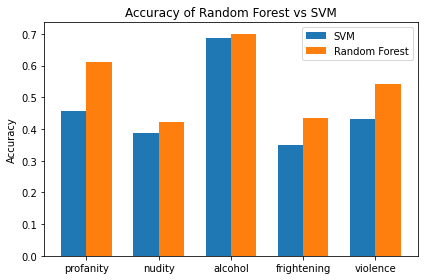

In [40]:
# Take accuracy keys as labels (aspects)
labels = list(accuracy_dict.keys())
plot_metric(metric = 'Accuracy', joined_dict = accuracy_dict)


#### macro F1 Scores

In [51]:
macro_f1_score = {}
for key in macro_f1_dict_rf.keys() | macro_f1_dict_svm.keys():
    macro_f1_score[key] = [macro_f1_dict_svm.get(key), macro_f1_dict_rf.get(key)]

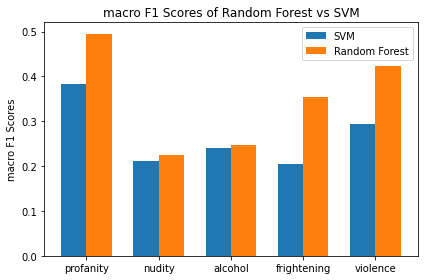

In [52]:
# Take macro scores since data is unbalanced
labels = list(macro_f1_score.keys())
plot_metric(metric = 'macro F1 Scores', joined_dict = macro_f1_score)
